In [1]:
from torchsummary import summary

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import numpy as np

from scipy import misc

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 5
num_classes = 10
batch_size = 32
learning_rate = 0.001

In [2]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


Files already downloaded and verified


In [3]:
import random

In [4]:
trainset.targets = [random.randint(0, 9) for _ in range(len(trainset))]

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [6]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
           )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.fc = nn.Linear(2048, num_classes)
        
    # 定义前向传播顺序
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [9]:
model = ConvNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(trainloader)
loss1_list=[]
acc1_list=[]
testloss_list=[]
testacc_list=[]
epoch_list=[]
for epoch in range(20):
    running_loss = 0.0
    running_corrects = 0
    test_total=0
    test_correct=0.0
    test_loss=0.0
    for i, (images, labels) in enumerate(trainloader):
        # 注意模型在GPU中，数据也要搬到GPU中
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        _,preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    for i,(images, labels) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss=criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
       
    print(epoch+1)
    print(running_loss/len(trainset))
    print(running_corrects.double().item()/len(trainset))
    print(test_loss/test_total)
    print(test_correct/test_total)
    epoch_list.append(epoch+1)
    loss1_list.append(running_loss/len(trainset))
    acc1_list.append(running_corrects.double().item()/len(trainset))
    testloss_list.append(test_loss/test_total)
    testacc_list.append(test_correct/test_total)

1
2.3397951184082033
0.10072
2.3009976348876955
0.086
2
2.3027120442962645
0.10574
2.3057251914978028
0.0984
3
2.30210093711853
0.10642
2.3012457901000976
0.1091
4
2.3009060427093506
0.111
2.3034577907562257
0.1025
5
2.299080374450684
0.11382
2.304606234359741
0.1214
6
2.2953384323120116
0.1215
2.301945801925659
0.1142
7
2.2911835412597656
0.12452
2.303183625793457
0.1247
8
2.2854258058166503
0.13306
2.3027036209106444
0.12
9
2.2801783950042727
0.13748
2.3095088088989257
0.1249
10
2.2745841387176515
0.14232
2.3186621543884276
0.1122
11
2.268597324676514
0.1455
2.3123813659667967
0.1218
12
2.2621119104003906
0.15214
2.328874366760254
0.1122
13
2.256652439804077
0.15672
2.325681944274902
0.1147
14
2.2503611669921875
0.16248
2.330715875244141
0.1163
15
2.2444257427978513
0.16466
2.3364800373077395
0.1099
16
2.236636667404175
0.17036
2.351435964202881
0.1073
17
2.231939412689209
0.17106
2.3584343227386473
0.1176
18
2.224285261154175
0.1795
2.3678759384155272
0.1052
19
2.2186184445953367
0.

In [13]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]           1,216
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]          12,832
       BatchNorm2d-6           [-1, 32, 16, 16]              64
              ReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Linear-9                   [-1, 10]          20,490
Total params: 34,634
Trainable params: 34,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.61
Params size (MB): 0.13
Estimated Total Size (MB): 0.75
---------------------------------------------

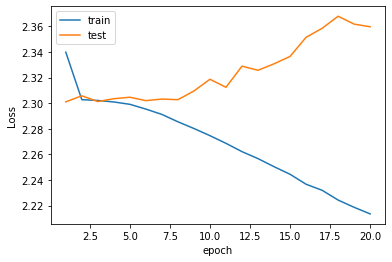

In [10]:
plt.plot(epoch_list, loss1_list,label="train")
plt.plot(epoch_list, testloss_list,label="test")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

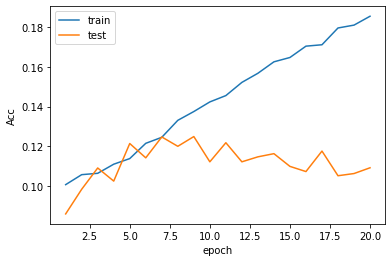

In [12]:
plt.plot(epoch_list, acc1_list,label="train")
plt.plot(epoch_list, testacc_list,label="test")
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend()
plt.show()